# Artificial neural network

In [204]:
from __future__ import division
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
import time
import csv
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from pandas import Series, DataFrame, Panel

from sklearn import svm
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble

## Configurations

In [205]:
# Location of datasets
directory_path = "~/code/datamining/proj3/datasets"

# Partition % of datasets
training_data_percentage = 70
validation_data_percentage = 15
test_data_percentage = 15

# Max number of iterations for minimization
opts = {'maxiter' : 50}

file1 = directory_path + "/project3_dataset1.txt"
file2 = directory_path + "/project3_dataset2.txt"

train_data_file3 = directory_path + "/dataset3" + "/train.txt"
train_label_file3 = directory_path + "/dataset3" + "/train_truth.txt"
test_data_file3 = directory_path + "/dataset3" + "/test.txt"

## Helper functions

#### For pre-processing, plotting and feature reduction

In [206]:
def applyPCA(X):
    pca = PCA(n_components=35)
    X_transformed = pca.fit_transform(X)
    return X_transformed

def generateLabelVector(x):
    vector = np.repeat(np.array([0]), 10, 0)
    vector[x] = 1
    return vector

def doFeatureSelection(train_data, validation_data, test_data):
    n_rows = train_data.shape[0]
    n_cols = train_data.shape[1]
    is_first_run = True
    
    new_train_data = train_data
    new_validation_data = validation_data
    new_test_data = test_data
    
    if train_data.shape[0]!=0:
        for i in range(n_cols):
            
            col_flag = False
            temp = train_data[0][i]
            
            for j in range(1, n_rows):
                if train_data[j][i] != temp:
                    col_flag = True
                    break
            if col_flag is True:
                if is_first_run is True:
                    new_train_data = np.array([train_data[:, i]]) # create matrix 
                    new_train_data = np.reshape(new_train_data, (n_rows, -1))
                    
                    new_validation_data = np.array([validation_data[:, i]]) # create matrix 
                    new_validation_data = np.reshape(new_validation_data, (validation_data.shape[0], -1))
                    
                    new_test_data = np.array([test_data[:, i]]) # create matrix 
                    new_test_data = np.reshape(new_test_data, (test_data.shape[0], -1))
                    
                    is_first_run = False;
                else:
                    tempmatrix = np.reshape(np.array([train_data[:, i].T]), (train_data.shape[0],-1))
                    new_train_data = np.append(new_train_data, tempmatrix, 1)
                    
                    tempmatrix = np.reshape(np.array([validation_data[:, i].T]), (validation_data.shape[0],-1))
                    new_validation_data = np.append(new_validation_data, tempmatrix, 1)
                    
                    tempmatrix = np.reshape(np.array([test_data[:, i].T]), (test_data.shape[0],-1))
                    new_test_data = np.append(new_test_data, tempmatrix, 1)
        
    return new_train_data, new_validation_data, new_test_data


def categorical_to_numeric(dataframe):
    for i in range(len(dataframe.columns)):
        val = dataframe[i].values[0]
        if (isinstance(val, str) and not val.isdigit()):
            column = dataframe[i].values
            unique_values = np.unique(column)
            mapper = {value: index for (index, value) in enumerate(unique_values)}

            dataframe.replace({i: mapper}, inplace=True)
    return dataframe

def get_data_partitions(filepath):
    # Make dataframe
    df = pd.read_csv(filepath, delimiter="\t", header=None)

    # Identify the categorical data columns and convert them to a numerical representation
    df = categorical_to_numeric(df)

    # Calculate sizes of partitions
    size_of_dataset = df.shape[0]
    train_size = int(training_data_percentage * size_of_dataset / 100.0)
    validation_size = int(validation_data_percentage * size_of_dataset / 100.0)
    test_size = int(test_data_percentage * size_of_dataset / 100.0)

    # Shuffle the rows
    df = df.iloc[np.random.permutation(len(df))]
    df = df.reset_index(drop=True)

    # Make partitions
    training_partition = df[:train_size].as_matrix()
    validation_partition = df[train_size:train_size+validation_size].as_matrix()
    test_partition = df[train_size+test_size:test_size+train_size+validation_size].as_matrix()

    return training_partition, validation_partition, test_partition

def get_labels(label_column):
    zeros = [(1 if x==0 else 0) for x in label_column]
    ones = [(0 if x==0 else 1) for x in label_column]
    labels = np.column_stack((zeros, ones))
    return labels

def get_data(filepath):
    training_partition, validation_partition, test_partition = get_data_partitions(filepath)

    # Make label data
    training_labels = get_labels(training_partition[:, -1])
    validation_labels = get_labels(validation_partition[:, -1])
    test_labels = get_labels(test_partition[:, -1])

    # Data (without the label column)
    train_data = training_partition[:,:-1]
    validation_data = validation_partition[:,:-1]
    test_data = test_partition[:,:-1]

     
    # Perform feature-selection
    train_data, validation_data, test_data = doFeatureSelection(train_data, validation_data, test_data)
#     train_data = applyPCA(train_data)
#     validation_data = applyPCA(validation_data)
#     test_data = applyPCA(test_data)
    
    return train_data, training_labels, validation_data, validation_labels, test_data, test_labels


# Plot functions
def plot_dataframe_results(df, lambda_val_list, n_hidden_list, has_test_labels=True):
    legend_location = 'upper center'
    figure = plt.figure()
    figure.set_size_inches(15.5, 5.5)
    
    plt.subplot(1, 2, 1)
    plt.plot(df['n_hidden'][:len(n_hidden_list)].values, df['train_acc'][:len(n_hidden_list)].values, label='Training set accuracy')
    plt.plot(df['n_hidden'][:len(n_hidden_list)].values, df['validation_acc'][:len(n_hidden_list)].values, label='Validation set accuracy')
    if has_test_labels:
        plt.plot(df['n_hidden'][:len(n_hidden_list)].values, df['test_acc'][:len(n_hidden_list)].values, label='Test set accuracy')
    plt.xlabel('# of hidden units')
    plt.xticks(n_hidden_list[4::5])
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(loc=legend_location, bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)
    
    plt.subplot(1, 2, 2)
    plt.plot(df['lambda'][len(n_hidden_list):].values, df['train_acc'][len(n_hidden_list):].values, label='Training set accuracy')
    plt.plot(df['lambda'][len(n_hidden_list):].values, df['validation_acc'][len(n_hidden_list):].values, label='Validation set accuracy')
    if has_test_labels:
        plt.plot(df['lambda'][len(n_hidden_list):].values, df['test_acc'][len(n_hidden_list):].values, label='Test set accuracy')
    plt.xlabel('lambda')
    plt.xticks(lambda_val_list[1::2])
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(loc=legend_location, bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)
    

## 10-fold cross validation

In [207]:
def get_evaluation_results(test_label, predicted_test_label):
    # Find total number of FP (false positives), FN, TP, TN
    tp = sum([1 if x==1 and y==1 else 0 for x,y in zip(test_label, predicted_test_label)])
    tn = sum([1 if x==0 and y==0 else 0 for x,y in zip(test_label, predicted_test_label)])
    fn = sum([1 if x==1 and y==0 else 0 for x,y in zip(test_label, predicted_test_label)])
    fp = sum([1 if x==0 and y==1 else 0 for x,y in zip(test_label, predicted_test_label)])

    # Calculate precision, recall, f-measure and accuracy
    precision = 0.0
    recall = 0.0
    ppv = 0.0
    tpr=0.0
    npv=0.0
    tnr=0.0
    if tp > 0:
        ppv = tp / (tp + fp)
        tpr = tp / (tp + fn)
    if tn > 0:
        npv = tn / (tn + fn)
        tnr = tn / (tn + fp)
    precision = (ppv+npv)/2
    recall = (tpr+tnr)/2
    accuracy = ((tp + tn) / test_label.shape[0])
    fmeasure = ((2.0 * recall * precision) / (recall + precision))
    return precision, recall, accuracy, fmeasure

# Perform 10-fold cross validation
#def do_cross_validation(filename, n_hidden, lambda_val, num_of_iterations = 10):
def do_cross_validation(filename, n_hidden, lambda_val, init_lambda_val, num_of_iterations = 10):
    avg_precision = 0.0
    avg_recall = 0.0
    avg_fmeasure = 0.0
    avg_accuracy = 0.0
    
    # Ranges of values of lambda and num of hidden units we will try
    lambda_val_list = np.arange(0.05, 0.4, 0.05)
    n_hidden_list = range(1, 60, 5)

    print "\nPerforming 10-fold cross validation."
    for i in range(num_of_iterations):
        
        # Get randomized samples of data
        train_data, train_label, validation_data,validation_label, test_data, test_label = get_data(filename)

#         df, predicted_test_label, optimum_n_hidden2, optimum_lambda2, max_accuracy, time_taken = run_main_code(train_data, train_label, validation_data,validation_label, test_data, test_label, lambda_val_list, n_hidden_list, lambda_val = init_lambda_val)


        # Initialize the weights into some random matrices
        n_input = train_data.shape[1]
        n_class = 2
        initial_w1 = initializeWeights(n_input, n_hidden);
        initial_w2 = initializeWeights(n_hidden, n_class);

        # Combine the 2 weight matrices into single column vector
        initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

        # Run the minimize function
        args = (n_input, n_hidden, n_class, train_data, train_label, lambda_val)
        w1, w2, training_set_accuracy, validation_set_accuracy, test_set_accuracy, predicted_test_label = runCode(initialWeights, args, opts, validation_data, validation_label, test_data, test_label)

        # Get precision, recall etc
        test_label = test_label.argmax(axis=1)
        precision, recall, accuracy, fmeasure = get_evaluation_results(test_label, predicted_test_label)
        
        avg_precision += precision
        avg_recall += recall
        avg_accuracy += accuracy
        avg_fmeasure += fmeasure

    avg_precision /= num_of_iterations
    avg_recall /= num_of_iterations
    avg_fmeasure /= num_of_iterations
    avg_accuracy /= num_of_iterations

    print "Cross validation complete."
    print '\nPrecision =', avg_precision, '\nRecall =', avg_recall, '\nAccuracy =', avg_accuracy, '\nF-measure =', avg_fmeasure

## Neural network function definitions

In [208]:
def initializeWeights(n_in, n_out):
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1);
    W = (np.random.rand(n_out, n_in + 1)*2* epsilon) - epsilon;
    return W

def sigmoid(z):
    return (1 / (1 + np.exp(-1 * z)))    

def nnObjFunction(params, *args):

    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args
    
    w1 = params[0:(n_hidden) * (n_input + 1)].reshape( (n_hidden, (n_input + 1)))
    w2 = params[((n_hidden) * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    obj_val = 0  
        
    w1_trans = np.transpose(w1)
    w2_trans = np.transpose(w2)

    n_examples = training_data.shape[0]
    
    #grad_w2 = output x hidden
    #grad_w1 = output x hidden 
    grad_w1 = np.zeros((n_hidden + 1, n_input + 1)) #initialize to 0  
    grad_w2 = np.zeros((n_class, n_hidden + 1)) #initialize to 0
    
    # === Add the (d+1)th bias attribute to training data as a column
    ones = np.repeat(np.array([[1]]), n_examples, 0)
    training_data = np.append(training_data, ones, 1)

    x = training_data

    z = sigmoid(np.dot(x, w1_trans))
    
    # Append bias (as a column vector [1,1,1...1]) to z
    ones = np.repeat(np.array([[1]]), z.shape[0], 0)
    z = np.append(z, ones, 1)
    
    o = sigmoid(np.dot(z, w2_trans))
    y = training_label

    #-----calculation for obj_grad-----
    delta = np.subtract(o, y)

    grad_w2 = np.add(grad_w2, (np.dot(delta.T, z)))
        
    prodzXsummation = (np.dot(delta, w2))*(z*(np.subtract(1.0, z)))

    grad_w1 = np.add(grad_w1,(np.dot(prodzXsummation.T, x)))

    j = y*(np.log(o)) + ((np.subtract(1.0, y))*(np.log(np.subtract(1.0, o))))
    jsum = np.sum(j)
        
    obj_val = np.sum(jsum)
        
                 
    # Make sure you reshape the gradient matrices to a 1D array. for instance 
    # if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    # obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)
    # obj_grad = np.array([])
  
    #grad_w1 = grad_w1 / n_examples
    # Remove the last row from grad_w1 (to match the dimensions)
    grad_w1=grad_w1[:-1,:]   
    #grad_w2 = grad_w2 / n_examples   
    
    obj_val = (obj_val/n_examples)*-1        
      
    #---------------------------regularization----------------------------     
    
    refact_w1_sum = np.sum(np.square(w1))
    refact_w2_sum = np.sum(np.square(w2))
    final_reg_term =(lambdaval/(2*n_examples))*(refact_w1_sum+refact_w2_sum)
    obj_val=obj_val+final_reg_term
    
    # Calculating the terms required for regularizing obj_grad
    lambdaw1= w1*lambdaval
    grad_w1 = (grad_w1+lambdaw1)/n_examples

    lambdaw2= w2*lambdaval
    grad_w2 = (grad_w2+lambdaw2)/n_examples
    
    #---------------------------/regularization----------------------------
    
    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)
    
    #print "obj_grad", obj_grad
#     print "obj_val",  obj_val
    
    global run_count
    run_count += 1
    
    #print("\n--------------------END - nnObjFunction------------------")
    
              
    return (obj_val,obj_grad)


def nnPredict(w1,w2,data):
        
    labels = np.array([])
        
    w1_trans = np.transpose(w1)
    
    # === Add the (d+1)th bias attribute to input layer data as a column
    ones = np.repeat(np.array([[1]]), data.shape[0], 0)
    data = np.append(data, ones, 1)
    x = data
    
    z = sigmoid(np.dot(x, w1_trans))
    
    # === Add the (d+1)th bias attribute to hidden layer data as a column
    ones = np.repeat(np.array([[1]]), z.shape[0], 0)
    z = np.append(z, ones, 1)

    # Get the output
    o = sigmoid(np.dot(z, w2.T))

    # The prediction is the index of the output unit with the max o/p
    labels = np.argmax(o, axis=1)
           
    return labels


def runCode(initialWeights, args, opts, validation_data,validation_label, test_data, test_label):

    global run_count
    run_count = 0
    
    n_input = args[0]
    n_hidden = args[1]
    n_class = args[2]
    train_data = args[3]
    train_label = args[4]

    # ===== Train Neural Network using fmin_cg or minimize from scipy, optimize module. Check documentation for a working example
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    
    # In case you want to use fmin_cg, you may have to split the nnObjectFunction to two functions nnObjFunctionVal
    # and nnObjGradient. Check documentation for this function before you proceed.
    # nn_params, cost = fmin_cg(nnObjFunctionVal, initialWeights, nnObjGradient,args = args, maxiter = 50)
    
    
    #====== We now have the trained weights ======
    # Reshape nnParams from 1D vector into w1 and w2 matrices
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape( (n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    
    # We need to convert the label matrices into column vectors
    train_label = train_label.argmax(axis=1)
    validation_label = validation_label.argmax(axis=1)
    
    
    
    #====== Test the computed parameters ======
    # Find the accuracy on the TRAINING Dataset
    predicted_label = nnPredict(w1,w2,train_data)
    training_set_accuracy = 100*np.mean((predicted_label == train_label).astype(float))
    #print('\n   Training set accuracy ==> ' + str(training_set_accuracy) + '%')
    
    # Find the accuracy on the VALIDATION Dataset
    predicted_label = nnPredict(w1,w2,validation_data)
    validation_set_accuracy = 100*np.mean((predicted_label == validation_label).astype(float))
    #print('   Validation set accuracy ==> ' + str(validation_set_accuracy) + '%')
    
    #find the accuracy on the TEST Dataset
    predicted_label = nnPredict(w1,w2,test_data)
    if test_label is not None:
        test_label = test_label.argmax(axis=1)
        test_set_accuracy = 100*np.mean((predicted_label == test_label).astype(float))
    else:
        test_set_accuracy = None
    #print('   Test set accuracy: ==> ' + str(test_set_accuracy) + '%')

    return w1, w2, training_set_accuracy, validation_set_accuracy, test_set_accuracy, predicted_label
    
    
run_count = 0
def run_main_code(train_data, train_label, validation_data,validation_label, test_data, test_label, lambda_val_list, n_hidden_list, lambda_val=0.1):
    """ Main code begins """

    overall_start_time = time.time()

    # Number of nodes in the input layer = the number of features
    n_input = train_data.shape[1];

    # Output layer nodes = # of classes = 2
    n_class = 2;

    # Make empty dataframe
    col_list = ['lambda', 'n_hidden', 'train_acc', 'validation_acc', 'test_acc', 'runs', 'time']
    df = pd.DataFrame(np.nan, index=[0], columns=col_list)
    df_index = 0

    # ====== Train Neural Network ====== #
    optimum_w1 = None
    optimum_w2 = None

    # ---- For different n_hidden values ---- #
    max_accuracy = 0.0
    optimum_n_hidden = 0.0
    
    for n_hidden in n_hidden_list:
        code_start_time = time.time()
    #     print 'n_hidden = %d' %n_hidden

        # Initialize the weights into some random matrices
        initial_w1 = initializeWeights(n_input, n_hidden);
        initial_w2 = initializeWeights(n_hidden, n_class);

        # Combine the 2 weight matrices into single column vector
        initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

        # Run the minimize function
        args = (n_input, n_hidden, n_class, train_data, train_label, lambda_val)
        w1, w2, training_set_accuracy, validation_set_accuracy, test_set_accuracy, predicted_test_label = runCode(initialWeights, args, opts, validation_data, validation_label, test_data, test_label)

        time_taken = (time.time() - code_start_time)/60.0

        # Write to dataframe
        df.loc[df_index] = [lambda_val, n_hidden, training_set_accuracy, validation_set_accuracy, test_set_accuracy, run_count, time_taken]
        df_index += 1

        # Get the most optimum lambda value
        accu = test_set_accuracy
        if test_set_accuracy is None:
            accu = validation_set_accuracy
        if max_accuracy < accu:
            max_accuracy = accu
            optimum_n_hidden = n_hidden
            
            
    # ---- For different lambda values ---- #
    n_hidden = optimum_n_hidden
    max_accuracy = 0.0
    optimum_lambda = 0.0
    predicted_labels_best_case = []
    
    # Initialize the weights into some random matrices
    initial_w1 = initializeWeights(n_input, n_hidden);
    initial_w2 = initializeWeights(n_hidden, n_class);

    # Combine the 2 weight matrices into single column vector
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)
    
    for lambda_val in lambda_val_list:
        code_start_time = time.time()
    #     print 'Lambda = %.2f' %lambda_val

        # Run the minimize function
        args = (n_input, n_hidden, n_class, train_data, train_label, lambda_val)
        w1, w2, training_set_accuracy, validation_set_accuracy, test_set_accuracy, predicted_test_label = runCode(initialWeights, args, opts, validation_data, validation_label, test_data, test_label)

        time_taken = (time.time() - code_start_time)/60.0

        # Write to dataframe
        df.loc[df_index] = [lambda_val, n_hidden, training_set_accuracy, validation_set_accuracy, test_set_accuracy, run_count, time_taken]
        df_index += 1

        # Get the most optimum lambda value
        accu = test_set_accuracy
        if test_set_accuracy is None:
            accu = validation_set_accuracy
        if max_accuracy < accu:
            max_accuracy = accu
            optimum_lambda = lambda_val
            predicted_labels_best_case = predicted_test_label

    time_taken = "{0:.3f}".format((time.time() - overall_start_time)/60)
    accuracy_val = "{0:.2f}%".format(max_accuracy)

    return df, predicted_test_label, optimum_n_hidden, optimum_lambda, accuracy_val, time_taken

# Dataset 1

#### Results of training the 1st dataset with the neural network model. In order to find the most optimum values of lambda and hidden_units, the values were varied over a range and the ones with the highest accuracy were chosen as the most optimum ones.<br><br>Lambda was varied from 0.05 to 1, in increments of 0.05<br>Number of hidden units was varied from 1 to 80, in increments of 1

Reading data.
Training model.

Optimum # of hidden units = 46
Optimum lambda value = 0.9
Execution complete. Total execution time: 0.496 seconds.
Accuracy on the test dataset = 94.12%

Performing 10-fold cross validation.
Cross validation complete.

Precision = 0.897102263468 
Recall = 0.876222857813 
Accuracy = 0.896470588235 
F-measure = 0.886325928179


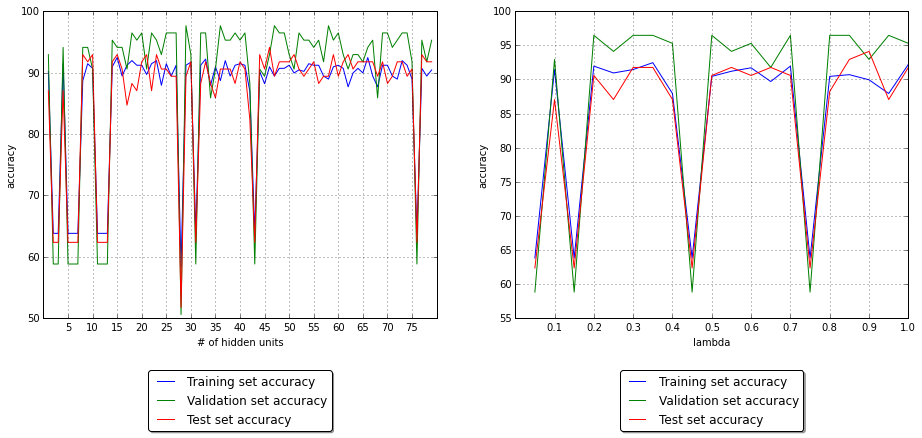

In [209]:
# Ranges of values of lambda and num of hidden units we will try
lambda_val_list = np.arange(0.05, 1.05, 0.05)
n_hidden_list = range(1, 80, 1)

print "Reading data."
train_data, train_label, validation_data,validation_label, test_data, test_label = get_data(file1)

print "Training model."
init_lambda_val=0.12
df, predicted_test_label, optimum_n_hidden1, optimum_lambda1, max_accuracy, time_taken = run_main_code(train_data, train_label, validation_data, validation_label, test_data, test_label, lambda_val_list, n_hidden_list, lambda_val=init_lambda_val)
print '\nOptimum # of hidden units =', optimum_n_hidden1
print 'Optimum lambda value =', optimum_lambda1
print "Execution complete. Total execution time:", time_taken, "seconds."
print 'Accuracy on the test dataset =', max_accuracy

plot_dataframe_results(df, lambda_val_list, n_hidden_list)
# print '\n', df
do_cross_validation(filename=file1, n_hidden=optimum_n_hidden1, lambda_val=optimum_lambda1, init_lambda_val=init_lambda_val)

# Dataset 2

#### Results of training the 2nd dataset with the neural network model. In order to find the most optimum values of lambda and hidden_units, the values were varied over a range and the ones with the highest accuracy were chosen as the most optimum ones.<br><br>Lambda was varied from 0.05 to 1, in increments of 0.05<br>Number of hidden units was varied from 1 to 80, in increments of 1

Reading data.
Training model.

Optimum # of hidden units = 76
Optimum lambda value = 0.3
Execution complete. Total execution time: 0.152 seconds.
Accuracy on the test dataset = 71.01%

Performing 10-fold cross validation.
Cross validation complete.

Precision = 0.566521645573 
Recall = 0.547961556292 
Accuracy = 0.657971014493 
F-measure = 0.552801184895


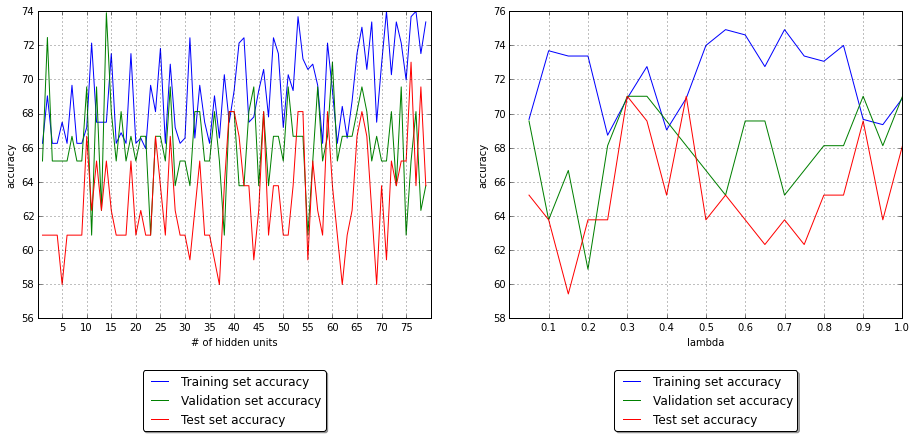

In [214]:
print "Reading data."
train_data, train_label, validation_data, validation_label, test_data, test_label = get_data(file2)

print "Training model."
init_lambda_val=0.25
df, predicted_test_label, optimum_n_hidden2, optimum_lambda2, max_accuracy, time_taken = run_main_code(train_data, train_label, validation_data,validation_label, test_data, test_label, lambda_val_list, n_hidden_list, lambda_val = init_lambda_val)
print '\nOptimum # of hidden units =', optimum_n_hidden2
print 'Optimum lambda value =', optimum_lambda2
print "Execution complete. Total execution time:", time_taken, "seconds."
print 'Accuracy on the test dataset =', max_accuracy

plot_dataframe_results(df, lambda_val_list, n_hidden_list)
# print '\n', df
do_cross_validation(filename=file2, n_hidden=optimum_n_hidden2, lambda_val=optimum_lambda2, init_lambda_val=init_lambda_val)

In [215]:
df

,lambda,n_hidden,train_acc,validation_acc,test_acc,runs,time
0,0.25,1,66.253870,65.217391,60.869565,16,0.000139
1,0.25,2,69.040248,72.463768,60.869565,146,0.000779
2,0.25,3,66.253870,65.217391,60.869565,121,0.000623
3,0.25,4,66.253870,65.217391,60.869565,119,0.000637
4,0.25,5,67.492260,65.217391,57.971014,118,0.000645
5,0.25,6,66.253870,65.217391,60.869565,138,0.000880
6,0.25,7,69.659443,66.666667,60.869565,127,0.000776
7,0.25,8,66.253870,65.217391,60.869565,15,0.000126
8,0.25,9,66.253870,65.217391,60.869565,121,0.000828
9,0.25,10,67.182663,69.565217,66.666667,123,0.000860


# 3rd dataset
### 7005 features and only 35 training examples

------------ Dataset 3 ------------

Features reduced from 7004 to 35 with PCA

Optimum # of hidden units = 1
Optimum lambda value = 0.05
Execution complete. Total execution time: 0.057 seconds.
Accuracy on the validation dataset = 57.14%

Predicted labels for test data:
[1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0]


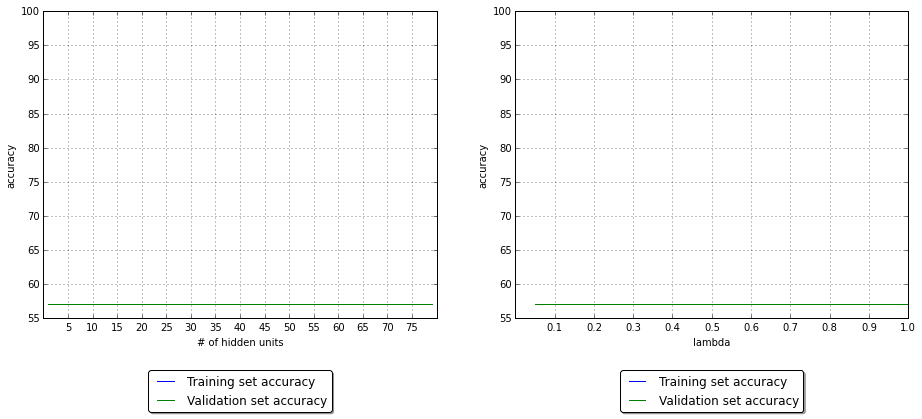

In [211]:
# Dataset 3
print "------------ Dataset 3 ------------"

def get_3rd_dataset(training_data_percentage = 80, validation_data_percentage = 20):
    
    # Read datasets
    train_df = pd.read_csv(train_data_file3, delimiter=" ", header=None).transpose()
    train_label_df = pd.read_csv(train_label_file3, delimiter=" ", header=None)
    test_df = pd.read_csv(test_data_file3, delimiter=" ", header=None).transpose()

    # Shuffle the rows
    random_perm = np.random.permutation(len(train_df))
    train_df = train_df.iloc[random_perm]
    train_df = train_df.reset_index(drop=True)
    train_label_df = train_label_df.iloc[random_perm]
    train_label_df = train_label_df.reset_index(drop=True)
    
    # Perform feature-selection with PCA
    train_df = pd.DataFrame(applyPCA(train_df.as_matrix()))
    test_df = pd.DataFrame(applyPCA(test_df.as_matrix()))
    
    # Calculate sizes of partitions
    size_of_dataset = train_df.shape[0]
    train_size = int(training_data_percentage * size_of_dataset / 100.0)
    validation_size = int(validation_data_percentage * size_of_dataset / 100.0)

    # Make partitions
    train_data3 = train_df[:train_size].as_matrix()
    validation_data3 = train_df[train_size:train_size+validation_size].as_matrix()
    test_data3 = test_df.as_matrix()

    # Make label data
    train_labels3 = get_labels(train_label_df[:train_size].as_matrix())
    validation_labels3 = get_labels(train_label_df[train_size:train_size+validation_size].as_matrix())

    # Perform feature-selection with PCA
    # train_data, validation_data, test_data = doFeatureSelection(train_data, validation_data, test_data)
#     train_data3 = applyPCA(train_data3)
#     validation_data3 = applyPCA(validation_data3)
#     test_data3 = applyPCA(test_data3)

    return train_data3, train_labels3, validation_data3, validation_labels3, test_data3

train_data3, train_labels3, validation_data3, validation_labels3, test_data3 = get_3rd_dataset()

# print train_data3.shape, train_labels3.shape, validation_data3.shape, validation_labels3.shape, test_data3.shape
print '\nFeatures reduced from', train_df.shape[1], 'to' ,train_data3.shape[1], "with PCA"

init_lambda_val=0.2
df, predicted_test_label, optimum_n_hidden3, optimum_lambda3, max_accuracy, time_taken = run_main_code(train_data3, train_labels3, validation_data3, validation_labels3, test_data3, None, lambda_val_list, n_hidden_list, lambda_val = init_lambda_val)
print '\nOptimum # of hidden units =', optimum_n_hidden3
print 'Optimum lambda value =', optimum_lambda3
print "Execution complete. Total execution time:", time_taken, "seconds."
print 'Accuracy on the validation dataset =', max_accuracy

# df, predicted_test_label, opt_nhidden, opt_lambda, max_accuracy, time_taken = run_main_code(train_data3, training_labels3, validation_data3, validation_labels3, test_data3, test_label=None, lambda_val_list, n_hidden_list,)
plot_dataframe_results(df, lambda_val_list, n_hidden_list, has_test_labels=False)
print "\nPredicted labels for test data:\n", predicted_test_label

In [212]:
def runModel_on_dataset3(clf):
    avg_precision = 0.0
    avg_recall = 0.0
    avg_fmeasure = 0.0
    avg_accuracy = 0.0
    num_of_iterations = 10

    for i in range(num_of_iterations):
        train_data3, train_labels3, validation_data3, validation_labels3, test_data3 = get_3rd_dataset()

        # Make labels a 1-D vector again
        train_labels3 = train_labels3.argmax(axis=1)
        validation_labels3 = validation_labels3.argmax(axis=1)

        # Fit and predict
        clf.fit(train_data3, train_labels3)
        predicted_validation_labels = clf.predict(validation_data3)

        # Get precision, recall etc
        precision, recall, accuracy, fmeasure = get_evaluation_results(validation_labels3, predicted_validation_labels)

        avg_precision += precision
        avg_recall += recall
        avg_accuracy += accuracy
        avg_fmeasure += fmeasure

    avg_precision /= num_of_iterations
    avg_recall /= num_of_iterations
    avg_fmeasure /= num_of_iterations
    avg_accuracy /= num_of_iterations

    print "Cross validation complete."
    print 'Precision =', avg_precision, '\nRecall =', avg_recall, '\nAccuracy =', avg_accuracy, '\nF-measure =', avg_fmeasure

    print "Predicted labels for test data:", clf.predict(test_data3)
    return avg_precision, avg_recall, avg_fmeasure, avg_accuracy
    

# Run multiple models
model_list = [linear_model.LogisticRegression(), svm.SVC(kernel='poly', degree=3), svm.SVC(kernel='rbf'), svm.SVC(kernel='sigmoid'), svm.SVC(kernel='linear'), ensemble.RandomForestClassifier(), GaussianNB()]
model_name_list = ['Logistic regression', 'SVM with poly kernel (degree=3)', 'SVM with RBF kernel', 'SVM with Sigmoid kernel', 'SVM with linear kernel', 'Random forest classifier', 'Gaussian Naive Bayes classifier']

prec_list = []
recall_list = []
fmeasure_list = []
acc_list = []
for model, model_name in zip(model_list, model_name_list):
    print "\nUsing model:", model_name
    avg_precision, avg_recall, avg_fmeasure, avg_accuracy = runModel_on_dataset3(model)
    prec_list.append(avg_precision)
    recall_list.append(avg_recall)
    fmeasure_list.append(avg_fmeasure)
    acc_list.append(avg_accuracy)



Using model: Logistic regression
Cross validation complete.
Precision = 0.587857142857 
Recall = 0.62 
Accuracy = 0.485714285714 
F-measure = 0.589598617757
Predicted labels for test data: [1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1]

Using model: SVM with poly kernel (degree=3)
Cross validation complete.
Precision = 0.446428571429 
Recall = 0.541666666667 
Accuracy = 0.7 
F-measure = 0.475152162652
Predicted labels for test data: [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1]

Using model: SVM with RBF kernel
Cross validation complete.
Precision = 0.328571428571 
Recall = 0.5 
Accuracy = 0.657142857143 
F-measure = 0.385052447552
Predicted labels for test data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Using model: SVM with Sigmoid kernel
Cross validation complete.
Precision = 0.328571428571 
Recall = 0.5 
Accuracy = 0.657142857143 
F-measure = 0.394638694639
Predicted labels for test data: [0 0 0 0 0 

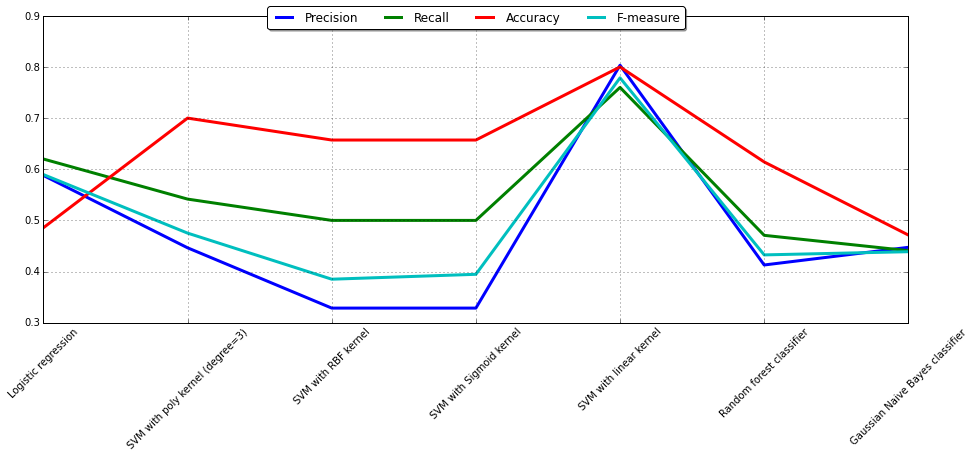

In [213]:
legend_location = 'upper center'
figure = plt.figure()
figure.set_size_inches(15.5, 5.5)
xlabs = range(len(model_name_list))

plt.plot(xlabs, prec_list, label='Precision',linewidth=3.0)
plt.plot(xlabs, recall_list, label='Recall',linewidth=3.0)
plt.plot(xlabs, acc_list, label='Accuracy',linewidth=3.0)
plt.plot(xlabs, fmeasure_list, label='F-measure',linewidth=3.0)
# plt.xlabel('lambda')
plt.xticks(xlabs, model_name_list, rotation=45)
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True, shadow=True)
    